In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random

In [ ]:
# Load CSV (update the path if needed)
df = pd.read_csv('/content/train.csv', on_bad_lines='skip')

# Extract text column, drop missing values, join into one big string

text = " ".join(df['text'].dropna().astype(str)).lower()

print(f'Total characters in text: {len(text)}')


Total characters in text: 35695884


In [ ]:
# Create vocabulary of unique characters
vocab = sorted(set(text))
print(f'Vocabulary size: {len(vocab)}')

# Character to index mapping and reverse
char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = np.array(vocab)

# Convert entire text to integers
text_as_int = np.array([char2idx[c] for c in text])


Vocabulary size: 104


In [ ]:
seq_length = 100  # input length per example

# Create dataset from integer encoded text
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# Batch into sequences (input + target)
sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

# Split sequences into input and target
def split_input_target(chunk):
    return chunk[:-1], chunk[1:]

dataset = sequences.map(split_input_target)

# Shuffle and batch dataset
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


In [ ]:
vocab_size = len(vocab)
embedding_dim = 64
rnn_units = 128

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(None,)),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
])


def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 104)      │        13,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,888 (464.41 KB)

 Trainable params: 118,888 (464.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 97s 17ms/step - loss: 2.0928
Epoch 2/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 137s 16ms/step - loss: 1.4935
Epoch 3/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 91s 16ms/step - loss: 1.4030
Epoch 4/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 90s 16ms/step - loss: 1.3645
Epoch 5/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 94s 17ms/step - loss: 1.3429
Epoch 6/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 90s 16ms/step - loss: 1.3281
Epoch 7/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 92s 16ms/step - loss: 1.3173
Epoch 8/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 141s 16ms/step - loss: 1.3091
Epoch 9/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 147s 17ms/step - loss: 1.3026
Epoch 10/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 90s 16ms/step - loss: 1.2973
Epoch 11/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 89s 16ms/step - loss: 1.2929
Epoch 12/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 92s 16ms/step - loss: 1.2893
Epoch 13/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 90s 16ms/step - loss: 1.2861
Epoch 14/20
5522/5522 ━━━━━━━━━━━━━━━━━━━━ 94s 17ms/step - loss: 1.283

In [ ]:
# Calculate average loss from training history
final_loss = history.history['loss'][-1]

# Compute perplexity
perplexity = np.exp(final_loss)
print(f"Final Loss: {final_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")


Final Loss: 1.2696
Perplexity: 3.5593


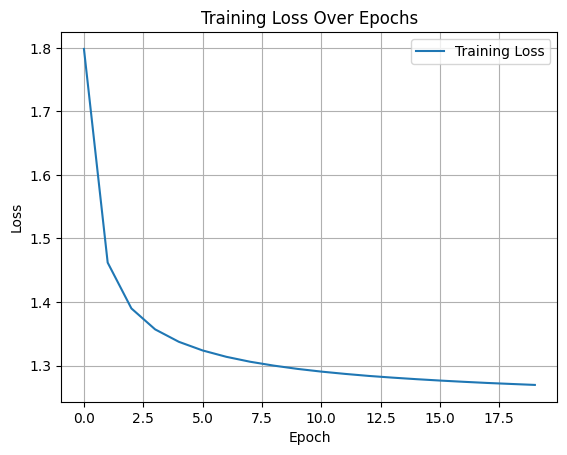

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    input_eval = [char2idx.get(s, 0) for s in start_string.lower()]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    model.layers[1].reset_states()  # Reset LSTM layer states

    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0) / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return start_string + ''.join(text_generated)


In [ ]:
print(generate_text(model, start_string="The ", num_generate=200, temperature=0.8))

The f onsthed jator irily, arunepla  sedemat. handaind an fol meche owede n  mpemery sth ound waticcexind (ret al stofutingey uren thoreche sher p atr p wisaruty ith tonct alld saitha st. h ok byomemer as
